<a href="https://colab.research.google.com/github/kobzarenko/paper_IT_2022/blob/main/Conv1D_wind_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***КЛАССИФИКАЦИЯ МЕТЕОРОЛОГИЧЕСКОЙ СТАНЦИИ НА ОСНОВЕ ДАННЫХ ВРЕМЕННОГО РЯДА - СКОРОСТИ ВЕТРА С ПРИМЕНЕНИЕМ ОДНОМЕРНЫХ СВЕРТОЧНЫХ СЛОЕВ***

**МЕТЕОРОЛОГИЧЕСКИЕ СТАНЦИИ: Ахты, Дербент, Кочубей, Махачкала**

**Обучающая выборка 2011-2017гг.**

**Проверочная выборка 2018г.**

**Тестовая выборка 2019-2020гг.**

In [ ]:
# библиотеки....
import numpy as np 
import matplotlib.pyplot as plt 
import time
import os
import datetime
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.layers import Reshape, concatenate, Input, Dense, Dropout, BatchNormalization, Flatten
from tensorflow.keras.layers import Conv1D, SpatialDropout1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.optimizers import Adam, Adadelta
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import Callback
from google.colab import output
from IPython.display import clear_output
%matplotlib inline

Монтирование диска своего профиля гугл...

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


**============== !!! ЗАДАНИЕ ПАПКИ С КОТОРОЙ БУДЕТ ОСУЩЕСТВЛЯТЬСЯ ВЗАИМОДЕЙСТВИЕ !!! ==============**

**ВНИМАНИЕ!!! Именно в эту папку у Вас должны быть помещены рабочие массивы для обучающей, проверочной и тестовой выборки!**


In [ ]:
# У Вас тут должен быть указан свой путь!!!
path = '/content/drive/My Drive/_DATA/'

Чтение исходных данных из массивов выборки (подготовленных заранее), сформированных исходя из размера блока данных = 12 суток.

In [ ]:
train_x = np.load(path + 'train_x.npy')
train_y = np.load(path + 'train_y.npy')
val_x = np.load(path + 'val_x.npy')
val_y = np.load(path + 'val_y.npy')
test_x = np.load(path + 'test_x.npy')
test_y = np.load(path + 'test_y.npy')

ГЛОБАЛЬНЫЕ ПЕРЕМЕННЫЕ И ПАРАМЕТРЫ

In [ ]:
station_list = ['Ахты', 'Дербент', 'Кочубей', 'Махачкала'] # привязка названий станций к индексам

batch_size = 40

dropout = 0.1

activate_function = 'relu'

learning_rate = 5e-6

epochs_count = 50

МОДЕЛЬ

In [ ]:
# модель с параллельными ветками
def CreateModel(x_len, activation='linear', dropout=0.1):

  input = Input((x_len,)) 
  
  x = Reshape((x_len, 1))(input)
  
  x1 = SpatialDropout1D(dropout)(x)
  x1 = Conv1D(10, 3, activation=activation)(x1)
  x1 = MaxPooling1D(2)(x1)
  x1 = Flatten()(x1)
  x1 = Dense(500, activation=activation)(x1)
  x1 = Dropout(dropout)(x1)
  x1 = Dense(250, activation=activation)(x1)
  x1 = Dropout(dropout)(x1)

  x2 = SpatialDropout1D(dropout)(x)
  x2 = Conv1D(10, 5, activation=activation)(x2)
  x2 = MaxPooling1D(2)(x2)
  x2 = Flatten()(x2)
  x2 = Dense(500, activation=activation)(x2)
  x2 = Dropout(dropout)(x2)
  x2 = Dense(250, activation=activation)(x2)
  x2 = Dropout(dropout)(x2)

  x3 = SpatialDropout1D(dropout)(x)
  x3 = Conv1D(10, 7, activation=activation)(x3)
  x3 = MaxPooling1D(2)(x3)
  x3 = Flatten()(x3)
  x3 = Dense(500, activation=activation)(x3)
  x3 = Dropout(dropout)(x3)
  x3 = Dense(250, activation=activation)(x3)
  x3 = Dropout(dropout)(x3)

  x = concatenate([x1, x2, x3])
   
  x = Dense(2000, activation=activation)(x)
  x = Dropout(dropout)(x)
  
  x = Dense(1500, activation=activation)(x)
  x = Dropout(dropout)(x)
  
  x = Dense(1000, activation=activation)(x)
  x = Dropout(dropout)(x)
  
  x = Dense(500, activation=activation)(x)
  x = Dropout(dropout)(x)

  x = Dense(4, activation='softmax')(x) 

  return Model(input, x) 

CALLBACK для запоминания лучшей эпохи обучения

In [ ]:
class MyCallback(Callback):
  
  # инициализация
  def __init__(self, model, val_x, val_y, test_x, test_y):
    # модель
    self.model = model 
    # проверочная выборка
    self.val_x = val_x 
    self.val_y = val_y
    # тестовая выборка
    self.test_x = test_x 
    self.test_y = test_y
    # общая точность проверочная + тестовая
    self.best_total_accuracy = 0  
      
  # подсчет процента ошибок на проверочных данных  
  def calc_val_accuracy(self):
    counts = [0, 0, 0, 0]
    rights = [0, 0, 0, 0]
    y = self.model.predict(self.val_x)
    for i in range(self.val_y.shape[0]):
      y_pred = np.argmax(y[i])
      y_true = np.argmax(self.val_y[i])
      counts[y_true] += 1
      if y_true == y_pred:
        rights[y_true] += 1
    return sum(rights)/sum(counts) * 100

  # подсчет процента ошибок на тестовых данных  
  def calc_test_accuracy(self):
    counts = [0, 0, 0, 0]
    rights = [0, 0, 0, 0]
    y = self.model.predict(self.test_x)
    for i in range(self.test_y.shape[0]):
      y_pred = np.argmax(y[i])
      y_true = np.argmax(self.test_y[i])
      counts[y_true] += 1
      if y_true == y_pred:
        rights[y_true] += 1
    return sum(rights)/sum(counts) * 100
  
  # окончение каждой эпохи....
  def on_epoch_end(self, epoch, logs=None):
    accuracy = (self.calc_val_accuracy() + self.calc_test_accuracy()) / 2
    print('Эпоха', epoch+1, ' Точность на обучающем и проверочном наборах данных:', round(accuracy, 2))
    if accuracy > self.best_total_accuracy:
      self.best_total_accuracy = accuracy
      self.model.save_weights(path + 'model_best.h5')   

  # получение лучшей точности
  def get_best_total_accuracy(self):
    return self.best_total_accuracy


ЗАПУСК ЭКСПЕРИМЕНТОВ ОБУЧЕНИЯ НЕЙРОННОЙ СЕТИ

In [ ]:
accuracies_list = [] # список точностей на тестовой выборке для всех экспериментов

maximum = 0.0

tests_count = 20 # количество тестов

for i in range(tests_count): # очередной тест

  clear_output()

  print('Эксперимент ', i+1)

  # создание модели
  model = CreateModel(train_x.shape[1], activation=activate_function, dropout=dropout)  

  # компиляция
  model.compile(optimizer=Adam(learning_rate=learning_rate), loss="categorical_crossentropy", metrics=["accuracy"])

  # создаем колбэк
  cb = MyCallback(model, val_x, val_y, test_x, test_y)

  history = model.fit(train_x, 
                      train_y, 
                      batch_size = batch_size,
                      epochs= epochs_count, 
                      validation_data=(val_x, val_y), 
                      verbose=0, shuffle=True, 
                      callbacks=[cb])
  print('\nЛучшая точность на проверочной и тестовой выборке =', round(cb.get_best_total_accuracy(), 2), '%')
  print()
  model.load_weights(path + 'model_best.h5')
  counts = [0, 0, 0, 0]
  rights = [0, 0, 0, 0]
  confuses = [[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]]
  y = model.predict(test_x)
  for i in range(test_y.shape[0]):
    y_pred = np.argmax(y[i])
    y_true = np.argmax(test_y[i])
    counts[y_true] += 1
    confuses[y_true][y_pred] += 1 
    if y_true == y_pred:
      rights[y_true] += 1
  
  accuracy = sum(rights)/sum(counts)*100 # точность на тестовой выборке

  print('Общая точность на тестовой выборке:', round(accuracy, 2), '%')
  
  if accuracy > maximum: # сохранение весов лучшего эксперимента
    maximum = accuracy
    model.save_weights(path + 'model_best_exp.h5') 

  accuracies_list.append(accuracy) # сохранение точности

clear_output()

print('Эксперименты закончены')

Эксперименты закончены


In [ ]:
print('Среднее значение точности прогнозов для всех экспериментов на тестовой выборке', 
      round(sum(accuracies_list)/len(accuracies_list), 2), '%')
print('Минимальное значение точности прогнозов для всех экспериментов на тестовой выборке', 
      round(min(accuracies_list), 2), '%')
print('Максимальное значение точности прогнозов для всех экспериментов на тестовой выборке', 
      round(max(accuracies_list), 2), '%')

Среднее значение точности прогнозов для всех экспериментов на тестовой выборке 77.52 %
Минимальное значение точности прогнозов для всех экспериментов на тестовой выборке 75.0 %
Максимальное значение точности прогнозов для всех экспериментов на тестовой выборке 80.0 %


In [ ]:
# вывод результатов лучшего эксперимента

model.load_weights(path + 'model_best_exp.h5')
counts = [0, 0, 0, 0]
rights = [0, 0, 0, 0]
confuses = [[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]]
y = model.predict(test_x)
for i in range(test_y.shape[0]):
  y_pred = np.argmax(y[i])
  y_true = np.argmax(test_y[i])
  counts[y_true] += 1
  confuses[y_true][y_pred] += 1 
  if y_true == y_pred:
    rights[y_true] += 1
print('Общая точность на тестовом наборе данных:', round(sum(rights)/sum(counts)*100, 2), '%')
print('-------------------------------------------------------------------------')
for i in range(4):
  print('Точность классификации станции:', station_list[i], round(rights[i]/counts[i]*100, 2), '%')
  print('Ошибки по станциям:')
  for j in range(4):
    if i != j:
      print(station_list[j], '-', confuses[i][j]) 

Общая точность на тестовом наборе данных: 80.0 %
-------------------------------------------------------------------------
Точность классификации станции: Ахты 83.33 %
Ошибки по станциям:
Дербент - 6
Кочубей - 0
Махачкала - 4
Точность классификации станции: Дербент 80.0 %
Ошибки по станциям:
Ахты - 7
Кочубей - 0
Махачкала - 5
Точность классификации станции: Кочубей 80.0 %
Ошибки по станциям:
Ахты - 1
Дербент - 0
Махачкала - 11
Точность классификации станции: Махачкала 76.67 %
Ошибки по станциям:
Ахты - 1
Дербент - 9
Кочубей - 4


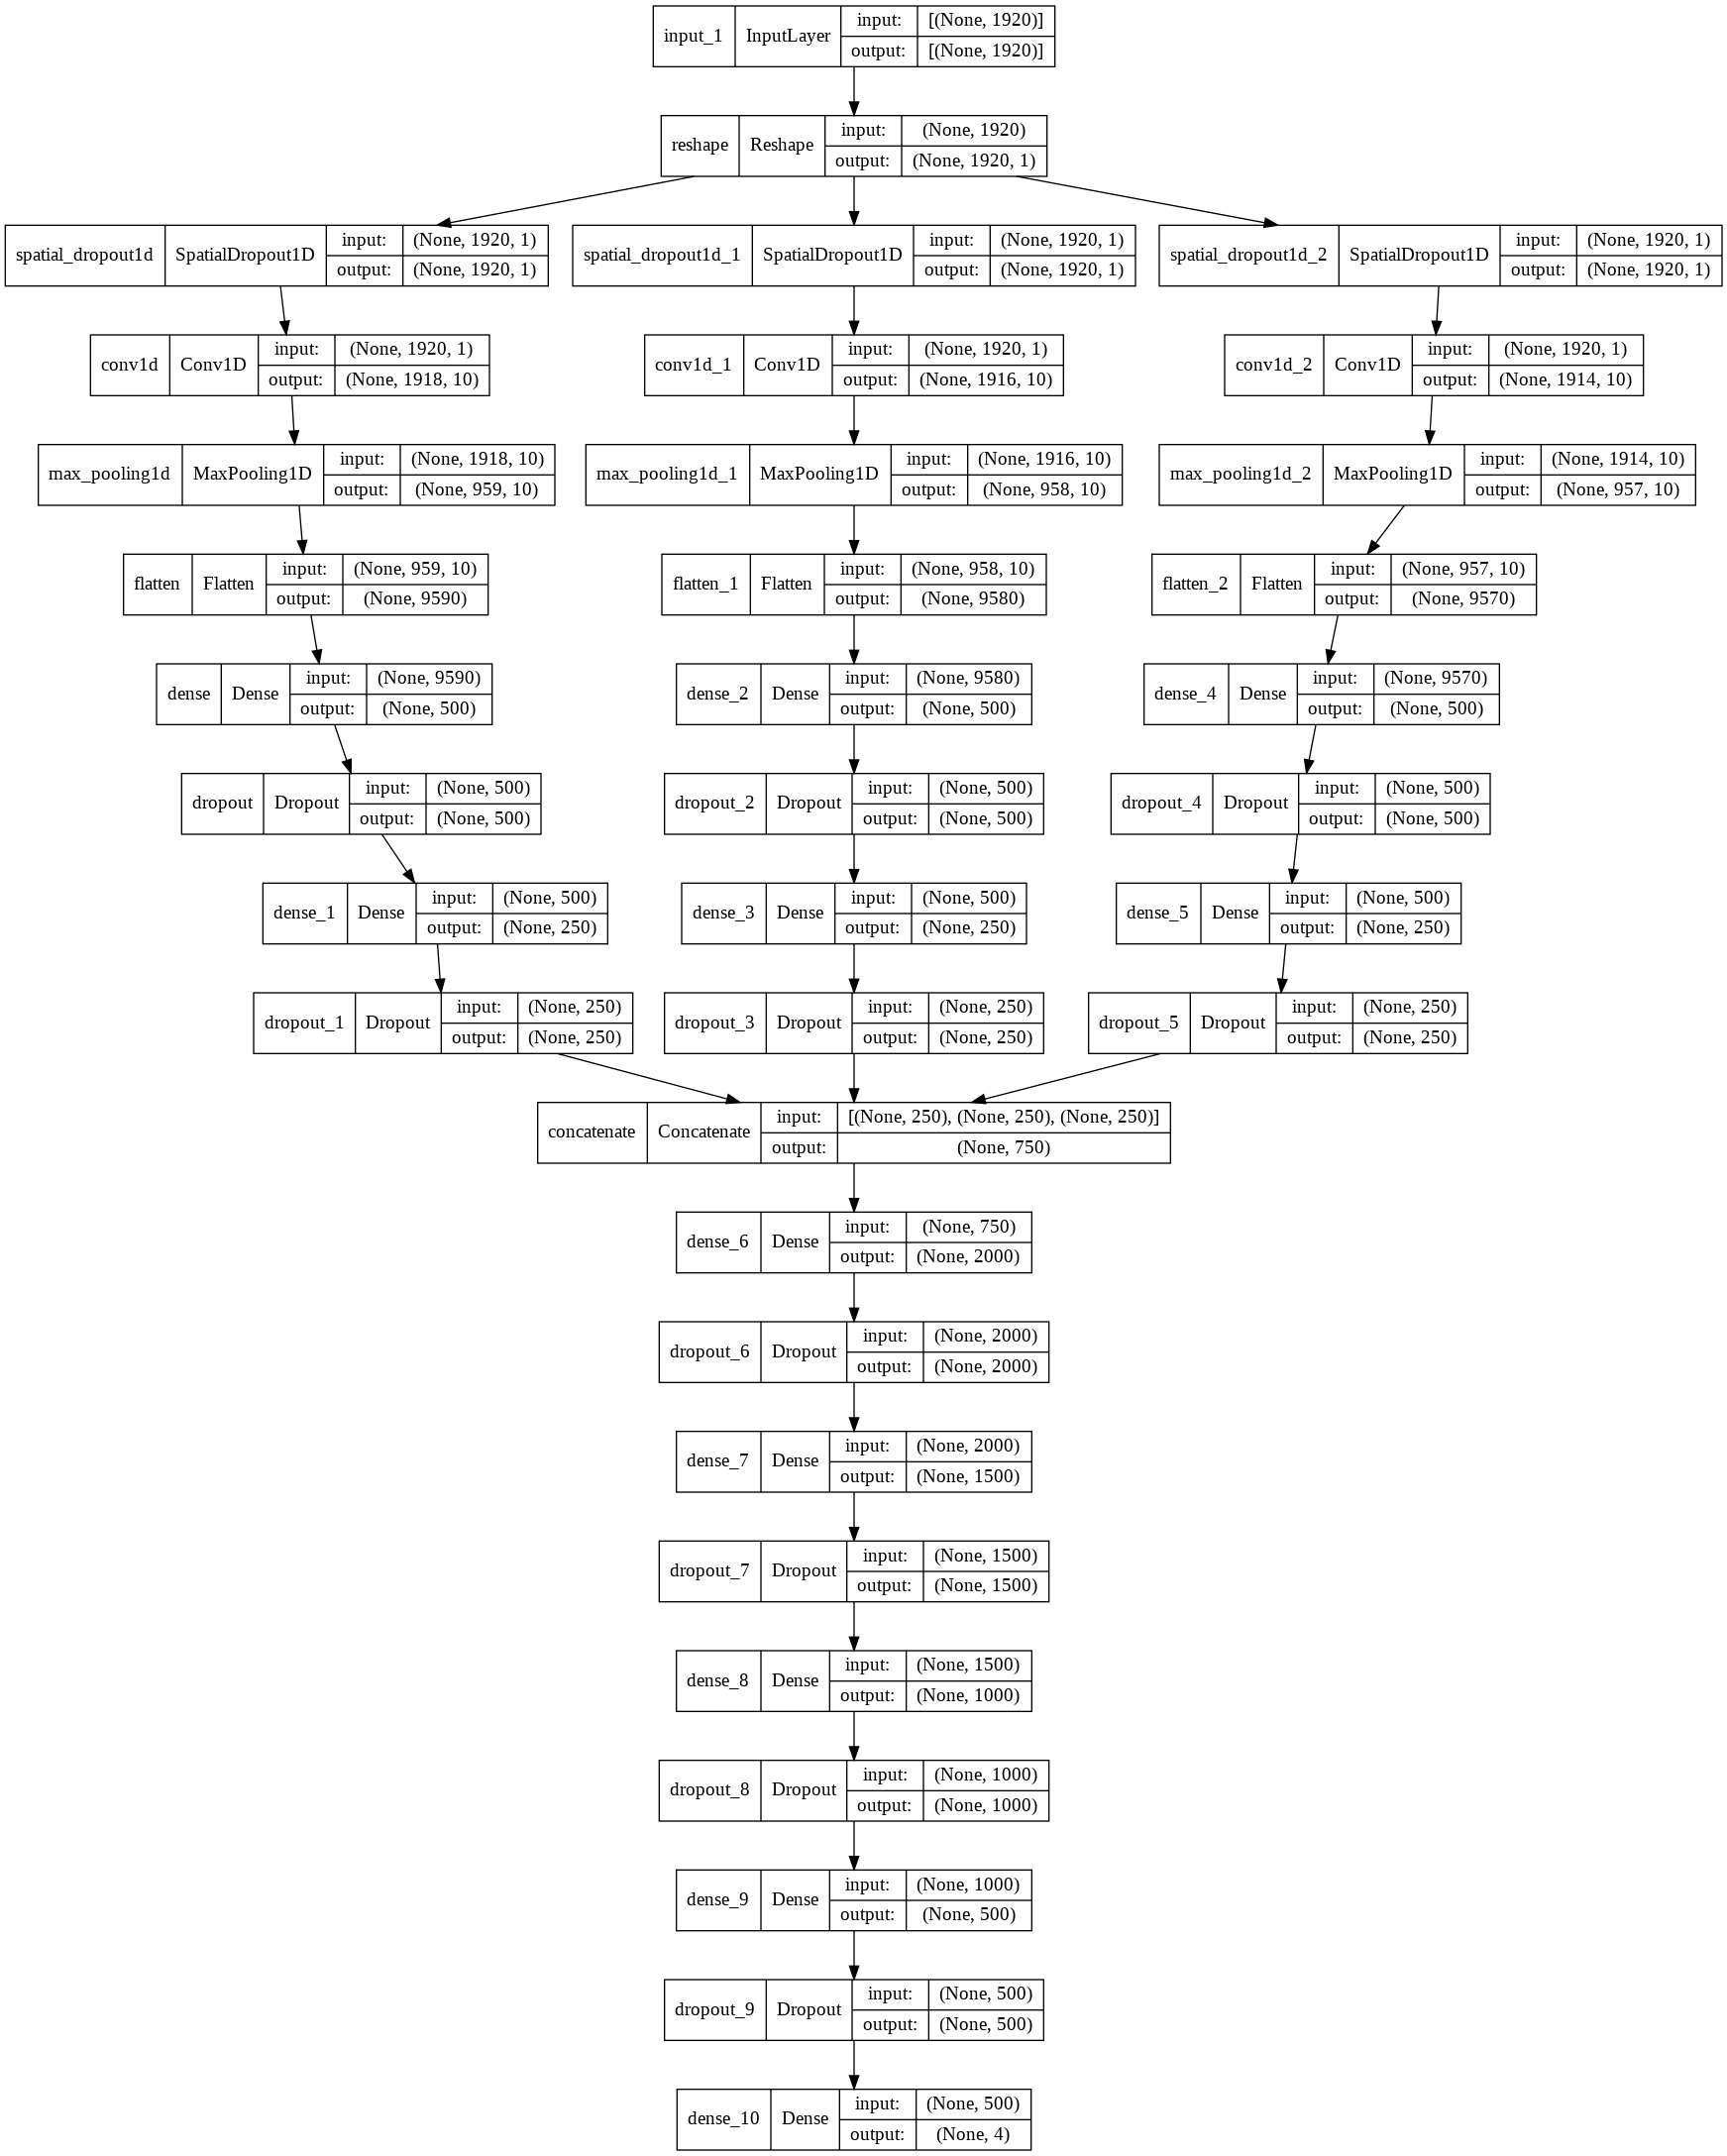

In [ ]:
# Вывод архитектуры модели на печать...
plot_model(model, show_shapes=True, show_layer_names=True)